In [28]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
import pandas as pd

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if tf.__version__ < '1.4.0':
  raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
tf.__version__

'1.5.0'

In [29]:
# This is needed to display the images.
%matplotlib inline

In [30]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [31]:
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = r'D:\Thesis\Models\faster_rcnn_resnet101_kitti_2018_01_28\frozen_inference_graph.pb'
# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'kitti_label_map.pbtxt')
NUM_CLASSES = 2

In [32]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [33]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [34]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [35]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

class,confidence,x,y,width,height,hue0,hue1,hue2,saturation,value
------------------------------------------------------------
2,1.00,1155.50,241.00,89.00,150.00,0.074,0.669,0.256,85.880,58.390
1,1.00,376.50,226.00,163.00,126.00,0.114,0.626,0.259,70.091,137.364
------------------------------------------------------------
1,1.00,347.50,225.50,159.00,127.00,0.104,0.614,0.282,66.123,148.577
2,1.00,1110.00,242.00,94.00,152.00,0.094,0.682,0.224,82.096,58.026
2,1.00,763.50,263.50,99.00,193.00,0.078,0.631,0.291,69.520,119.373


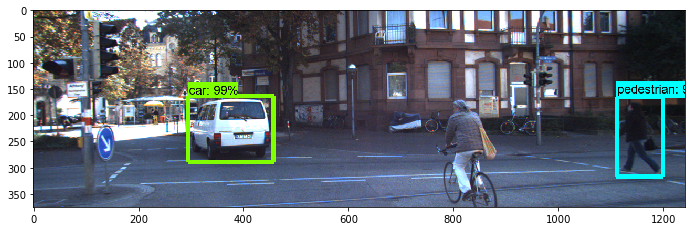

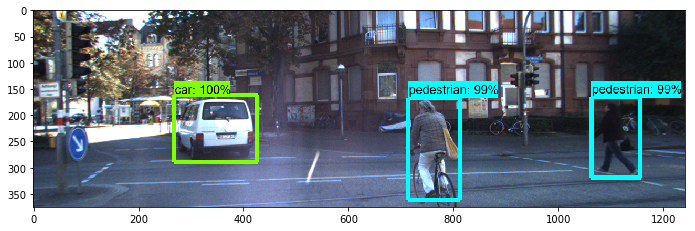

In [141]:
IMAGE_SIZE=IMAGE_SIZE = (12, 3.62)
image_paths = ['test_images/5-Left.png','test_images/5-Right.png']
print("class,confidence,x,y,width,height,hue0,hue1,hue2,saturation,value")
l_features_found = False
r_features_found = False
for image_path in image_paths:
    print(60*'-')
    image = Image.open(image_path)
    image_hsv = image.copy()
    image_hsv = image_hsv.convert('HSV')
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    image_np_hsv = load_image_into_numpy_array(image_hsv)
    image_height = image_np.shape[0]
    image_width = image_np.shape[1]
    image_np_original = image_np.copy()
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Extract features
    for i in range (output_dict['detection_scores'].shape[0]):
        if output_dict['detection_scores'][i] > 0.0:
            x_min = int(image_width*output_dict['detection_boxes'][i,1])
            x_max = int(image_width*output_dict['detection_boxes'][i,3])
            y_min = int(image_height*output_dict['detection_boxes'][i,0])
            y_max = int(image_height*output_dict['detection_boxes'][i,2])
            x_loc = (x_min + x_max) / 2
            y_loc = (y_min + y_max) / 2
            x_width = x_max - x_min
            y_height = y_max - y_min
            image_partial = image_np_hsv[y_min:y_max, x_min:x_max,:]
            histo, bins = np.histogram(image_partial[:,:,0], 3)
            histo = histo / sum(histo)
            sat_mean = np.mean(image_partial[:,:,1])
            val_mean = np.mean(image_partial[:,:,2])
            ic = output_dict['detection_classes'][i]
            print("{0:d},{1:.2f},{2:.2f},{3:.2f},{4:.2f},{5:.2f},{6:.3f},{7:.3f},{8:.3f},{9:.3f},{10:.3f}".format(ic,
                 output_dict['detection_scores'][i], x_loc, y_loc, x_width, y_height,
                 histo[0], histo[1], histo[2], sat_mean, val_mean))
            if "Left" in image_path:
                if l_features_found:
                    new_row = [[output_dict['detection_scores'][i]], [x_loc], [y_loc], [x_width], [y_height],
                         [histo[0]], [histo[1]], [histo[2]], [sat_mean], [val_mean]]
                    new_row = np.array(new_row).reshape((1,10))
                    l_features = np.vstack((l_features, new_row))
                else:
                    l_features = np.array([[output_dict['detection_scores'][i]], [x_loc], [y_loc], [x_width], [y_height],
                         [histo[0]], [histo[1]], [histo[2]], [sat_mean], [val_mean]])
                    l_features = l_features.reshape((1,10))
                    l_features_found = True
            else:
                if r_features_found:
                    new_row = [[output_dict['detection_scores'][i]], [x_loc], [y_loc], [x_width], [y_height],
                         [histo[0]], [histo[1]], [histo[2]], [sat_mean], [val_mean]]
                    new_row = np.array(new_row).reshape((1,10))
                    r_features = np.vstack((r_features, new_row))
                else:
                    r_features = np.array([[output_dict['detection_scores'][i]], [x_loc], [y_loc], [x_width], [y_height],
                         [histo[0]], [histo[1]], [histo[2]], [sat_mean], [val_mean]])
                    r_features_found = True
                    r_features = r_features.reshape((1,10))
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

In [142]:
mean = pd.read_pickle("stereomatch_mean.pkl")
covariance = pd.read_pickle("stereomatch_covariance.pkl")

In [143]:
mean_np = mean.as_matrix()
covariance_np = covariance.as_matrix()

In [144]:
l_features

array([[   1e+00,    1e+03,    2e+02,    9e+01,    2e+02,    7e-02,
           7e-01,    3e-01,    9e+01,    6e+01],
       [   1e+00,    4e+02,    2e+02,    2e+02,    1e+02,    1e-01,
           6e-01,    3e-01,    7e+01,    1e+02]])

In [145]:
r_features

array([[   1e+00,    3e+02,    2e+02,    2e+02,    1e+02,    1e-01,
           6e-01,    3e-01,    7e+01,    1e+02],
       [   1e+00,    1e+03,    2e+02,    9e+01,    2e+02,    9e-02,
           7e-01,    2e-01,    8e+01,    6e+01],
       [   1e+00,    8e+02,    3e+02,    1e+02,    2e+02,    8e-02,
           6e-01,    3e-01,    7e+01,    1e+02]])

In [146]:
l_features.shape

(2, 10)

In [147]:
r_features.shape

(3, 10)

In [148]:
len(l_features)

2

In [158]:
distance_matrix = np.zeros((len(l_features), len(r_features)))

In [159]:
distance_matrix

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [160]:
from scipy.stats import multivariate_normal
np.set_printoptions(precision=2)

In [161]:
for left_image in range(len(l_features)):
    for right_image in range((len(r_features))):
        p = multivariate_normal.pdf(l_features[left_image]-r_features[right_image], mean=mean_np, cov=covariance_np)
        p = -np.log(p)
        if np.isinf(p):
            p = 999.0
        distance_matrix[left_image][right_image] = p

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [162]:
np.set_printoptions(precision=0)
print(distance_matrix)

[[ 999.    6.  335.]
 [   6.  999.  571.]]


In [163]:
from scipy.optimize import linear_sum_assignment

In [164]:
row_ind, col_ind = linear_sum_assignment(distance_matrix)
print(row_ind)
print(col_ind)

[0 1]
[1 0]


In [168]:
multivariate_normal.pdf(mean_np, mean=mean_np, cov=covariance_np)

0.01